In [4]:
from arcgis.gis import GIS
gis = GIS ("home")

In [3]:
import os
import glob
import zipfile
from pathlib import Path
from arcgis.learn import prepare_data, MMDetection

# Cargar Imágenes 
Lo primero que haremos, será traer la imagen que utilizaremos para entrenar el modelo. El raster de entrada, es una imagen de 
alta resolución de la Ría de Arousa, Pontevedra, Galicia. La imagen tiene una resolución espacial de 30 centímetros, 3 bandas. 

<Item title:"mussel_farm_training_imagery" type:Imagery Layer owner:demos_deldev>
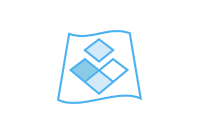

In [4]:
training_raster = gis.content.get('f2b92eed10394e5eb3c7f135861937d9')
training_raster

La siguiente capa de información (feature layer) contiene la delimitación de bateas en la Ría de Arousa. Este feature layer será utilizado como entrada de datos de entrenamiento. 

<Item title:"MusselFarms" type:Feature Layer Collection owner:api_data_owner>
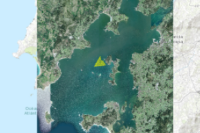

In [5]:
training_feature_layer = gis.content.get('ff6a48b3391c4a24b807af0eb08bb6c1')
training_feature_layer

Los datos de entrenamiento pueden ser exportados utilizando la herramienta 'Export Training Data For Deep Learning' disponible en ArcGIS Pro y ArcGIS Enterprise. Pare este ejemplo, hemos preparado los datos de entrenamiento en el formato 'PASCAL Visual Objects', utilizando un tamaño de los chips de 448px y un tamaño de celda de 0.3m, en ArcGIS Pro. 
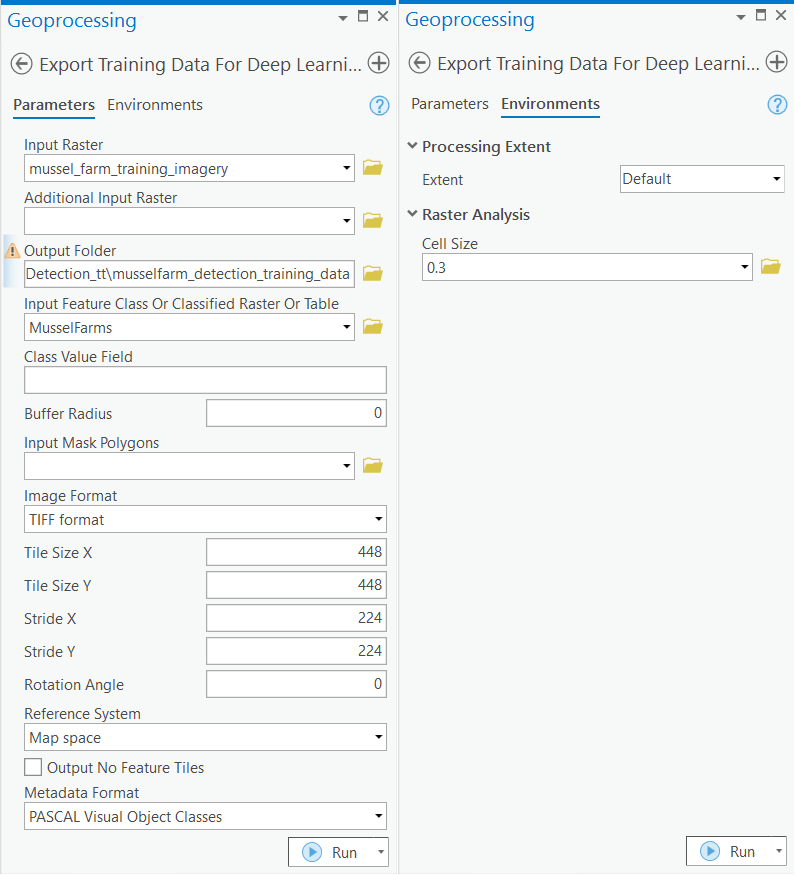
                                    Export Training Data for Deep Learning


# Entrenamiento del Modelo

In [6]:
import os
import glob
import zipfile
from pathlib import Path
from arcgis.learn import prepare_data, MMDetection

### Obtener datos de entrenamiento

<Item title:"musselfarm_detection_training_data" type:Image Collection owner:api_data_owner>
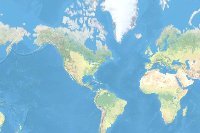

In [7]:
training_data = gis.content.get('57cb821dedca4c5598e81c8d2d510c91')
training_data

In [8]:
filepath = training_data.download(file_name=training_data.name)

In [ ]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path('D:\PROYECTOS\bateas').parent)

### Preparar Datos

A continuación, especificaremos la ruta a nuestros datos de entrenamiento y algunos hiperparámetros:
- path: path of the folder/list of folders containing training data.
- batch_size: Número de imágenes que el modelo entrenará en cada paso dentro de una época. Depende de la memoria de la tarjeta gráfica.
- chip_size: El mismo que el tamaño de tesela utilizado al exportar el conjunto de datos.

In [9]:
data = prepare_data(path= 'D:\musselfarm_detection_training_data', batch_size=4, chip_size=448)

### Visualizar datos entrenados

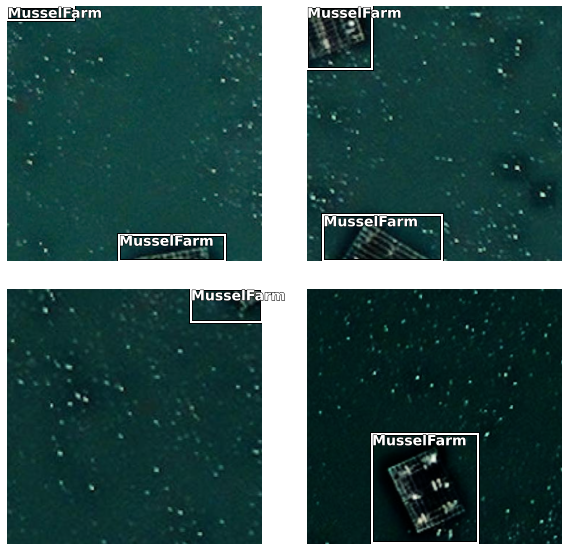

### Cargar la arquitectura del Modelo

Mediante la integración de la biblioteca MMDetection, arcgis.learn permite el uso del modelo Dynamic RCNN, junto con muchos otros modelos. Para obtener información más detallada sobre cómo usar MMDetection, consulte Usar MMDetection con arcgis.learn.

In [10]:
model = MMDetection(data, 'dynamic_rcnn')

### Learning Rate
La tasa de aprendizaje es uno de los hiperparámetros más importantes en el entrenamiento de modelos. La API de ArcGIS para Python proporciona un buscador de tasa de aprendizaje que elige automáticamente la tasa de aprendizaje óptima.

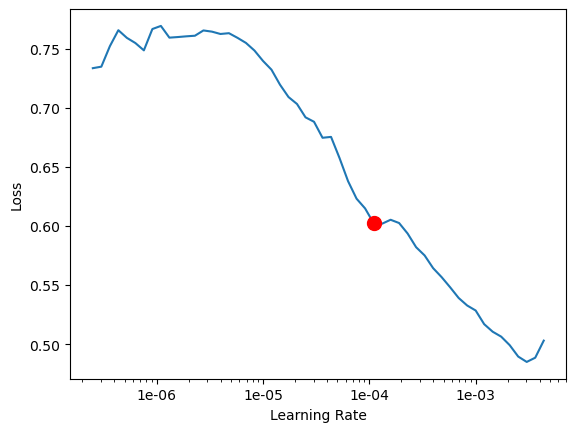

0.00010964781961431851

In [11]:
lr = model.lr_find() 
lr

### Ajustar el modelo
A continuación, entrenaremos el modelo durante 9 'epoch'. Se denomina 'epoch' a cada vez que un conjunto de datos pasa por un algoritmo. 

In [12]:
model.fit(10, lr=lr)

epoch     train_loss  valid_loss  average_precision  time    
0         0.487064    0.400560    0.778223           02:32     
1         0.387488    0.410933    0.824169           02:50     
2         0.324164    0.331451    0.866413           03:37     
3         0.327733    0.423682    0.840968           03:13     
4         0.353190    0.340170    0.882764           03:35     
5         0.293897    0.319296    0.881851           03:11     
6         0.271860    0.315574    0.859097           03:47     
7         0.262544    0.311217    0.891269           03:02     
8         0.246296    0.282777    0.890987           03:24     
9         0.249648    0.281399    0.891256           03:30     


### Visualizar los resultados en un dataset de validación
Una buena práctica es siempre visualizar los resultados. El siguiente código selecciona muestras aleatorias y nos muestra parámetros como 'ground truth' y las predicciones del modelo, una al lado de la otra. Esto nos permite obtener una vista previa de los resultados del modelo que entrenamos.



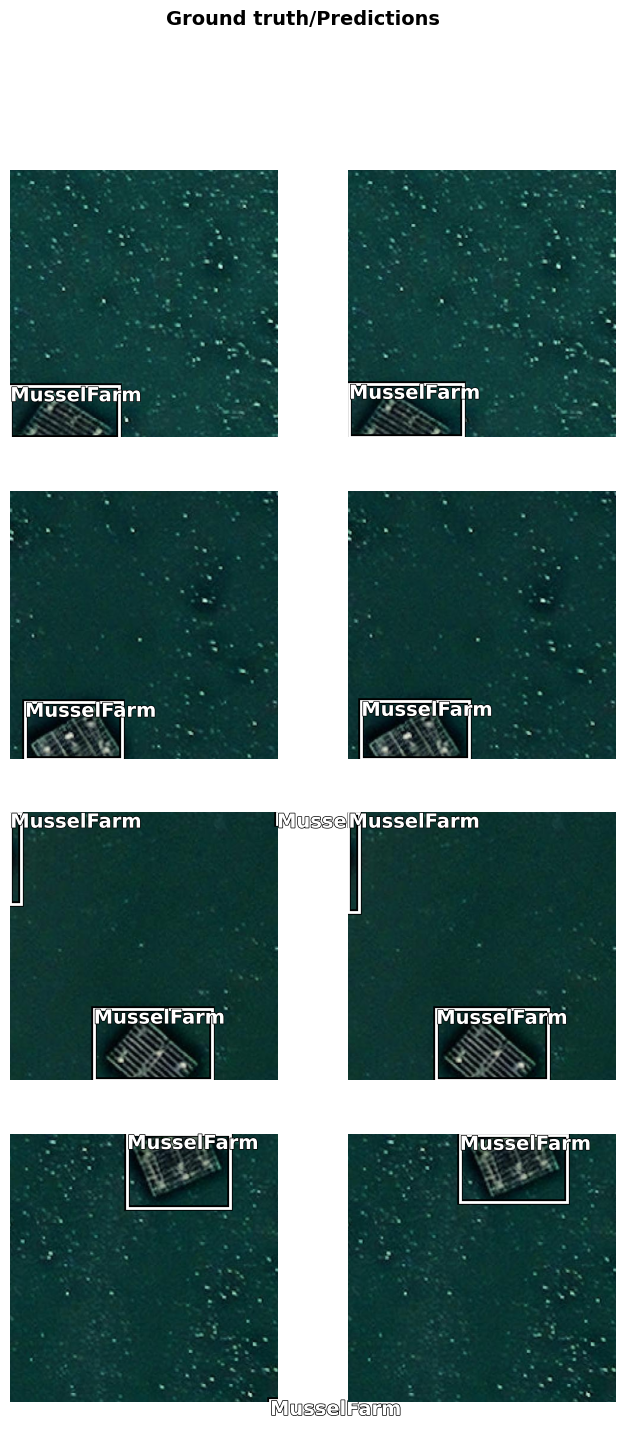

In [13]:
model.show_results()

### Evaluación de la precisión


arcgis.learn proporciona el método 'average_precision_score()' que calcula la precisión promedio del modelo en el conjunto de validación para cada clase.

In [15]:
model.average_precision_score()

{'MusselFarm': 0.8912560754978962}

### Guardar el modelo entrenado 

In [14]:
model.save('musselfarms_mmd_dynamic_rcnn_10ep')

Computing model metrics...


WindowsPath('D:/musselfarm_detection_training_data/models/musselfarms_mmd_dynamic_rcnn_10ep')

# Ejecutar el modelo entrenado y detectar bateas
Ahora podemos utilizar el modelo entrenado para detectar bateas en una imagen de alta resolución. 
Utilizaremos una imagen de 3 bandas (RGB) y de una resolución espacial de 30 cm.

<Item title:"mussel_farm_detection_test_imagery" type:Imagery Layer owner:demos_deldev>
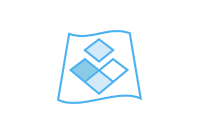

In [16]:
sample_inference_raster = gis.content.get('d6f035f5de504c86855e0ee70e83ad0e')
sample_inference_raster

### Combinar con herramientas GIS para optimizar los resultados
Para ahorrar tiempo, ejecutaremos el modelo solo en cuerpos de agua, considerando que las bateas solo se encuentran aquí. Una de las ventajas de trabajar al interior del Sistema ArcGIS es que vamos a poder combinar herramientas GIS y también contenido publicado en ArcGIS Online. En este caso, crearemos una máscara de agua utilizando la capa Sentinel-2 views NDWI y seguiremos el siguiente flujo de trabajo, compartido en este script. 

In [ ]:
model_builder = gis.content.get('2647a386f5a04917b74cc4f40a48f57f')
model_builder

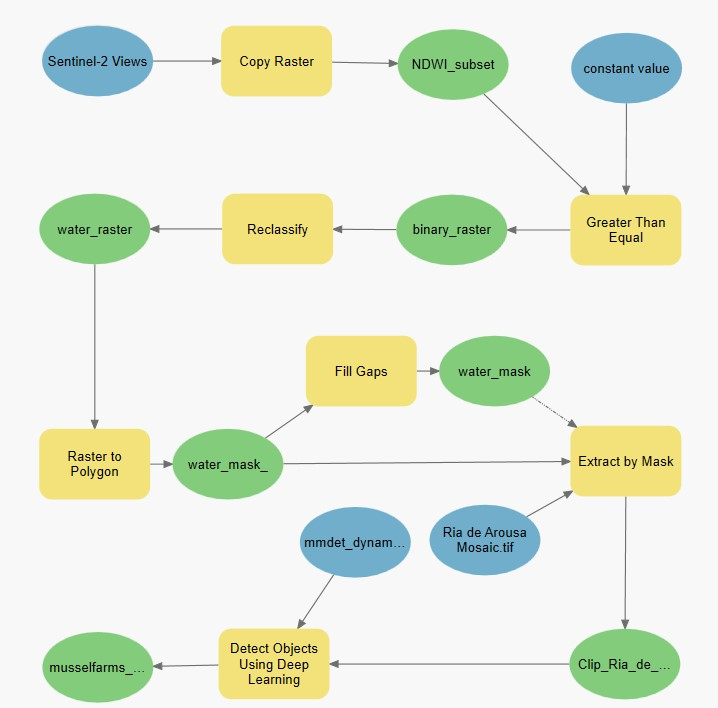

# Resultados

<Item title:"musselfarms_detected" type:Feature Layer Collection owner:demos_deldev>
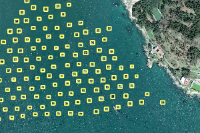

In [5]:
fc = gis.content.get('477d756f79e4400fa91c5b220406d98c')
fc

In [6]:
from arcgis.mapping import WebMap
wm_item = gis.content.get('c441ff66f4b64b6cbcad271b78a86294')

In [7]:
wm = WebMap(wm_item)
wm.add_layer(fc)
wm

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))